In [ ]:
import sys
print(sys.executable)

#!pip install six scikit-learn


d:\First Project\.venv\Scripts\python.exe
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.1 MB 9.4 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.1 MB 8.8 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.1 MB 8.4 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.1 MB 8.2 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.1 MB 8.0 MB/s eta 0:00:01
   ----------------------------------- ---- 10.0/11.1 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 7.7 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- -------

In [6]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from typing import Union, Literal, Tuple



In [7]:
# step 0: get the data 
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [8]:

def stratified_split(df: pd.DataFrame, target_column: str, test_size: float = 0.2, bins: int = 5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs a stratified train/test split that works for both categorical and continuous targets.

    Parameters:
        df (pd.DataFrame): Full dataset
        target_column (str): The column to stratify by
        test_size (float): Fraction of the dataset to allocate to test
        bins (int): Number of bins to use if target is continuous

    Returns:
        train_set (pd.DataFrame), test_set (pd.DataFrame)
    """
    df = df.copy()
    y = df[target_column]

    if pd.api.types.is_numeric_dtype(y) and y.nunique() > 10:
        # Continuous target: bin into quantiles
        df["_stratify_cat"] = pd.qcut(y, q=bins, duplicates='drop')
    else:
        # Already categorical
        df["_stratify_cat"] = y.astype(str)

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_idx, test_idx in splitter.split(df, df["_stratify_cat"]):
        strat_train_set = df.loc[train_idx].drop(columns="_stratify_cat")
        strat_test_set = df.loc[test_idx].drop(columns="_stratify_cat")

    return strat_train_set, strat_test_set


In [9]:
def frame_problem(df: pd.DataFrame, target_column: str):
    """
    Splits the dataframe into features (X) and target (y).
    
    Parameters:
        df (pd.DataFrame): The dataset
        target_column (str): The name of the target column

    Returns:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target vector
    """
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return X, y


In [10]:
#EDA function 
def explore_data(df: pd.DataFrame, target_column: str = None, sample_frac: float = 1.0) -> None:
    import seaborn as sns

    print("✅ Shape:", df.shape)
    print("\n🧠 Data Types:\n", df.dtypes)
    print("\n🔍 Missing Values:\n", df.isnull().sum())
    print("\n📈 Descriptive Statistics:\n", df.describe(include='all'))

    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=42)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(num_cols) > 0:
        num_plots = len(num_cols)
        cols = 3
        rows = (num_plots + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        axes = axes.flatten()

        for i, col in enumerate(num_cols):
            df[col].hist(bins=40, ax=axes[i])
            axes[i].set_title(col)
        
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])  # remove unused subplots

        fig.suptitle("📊 Numeric Feature Distributions", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # make room for suptitle
        plt.show()

    if target_column and target_column in df.columns:
        corr = df.corr(numeric_only=True)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
        plt.title("🔥 Feature Correlations")
        plt.show()

        sorted_corr = corr[target_column].drop(target_column).abs().sort_values(ascending=False)
        top_features = sorted_corr.head(3).index.tolist()

        for col in top_features:
            sns.scatterplot(data=df, x=col, y=target_column)
            plt.title(f"{col} vs {target_column}")
            plt.show()


### Let's now do the step 3: Prepare the Data for Machine Learning Algorithms

In [15]:
def prepare_data(df: pd.DataFrame) -> Tuple[np.ndarray, ColumnTransformer]:
    df = df.copy()

    # Force strings on object-like columns to prevent array confusion
    for col in df.columns:
        if df[col].dtype == "object" or df[col].dtype.name == "category":
            df[col] = df[col].astype(str)

    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_features = df.select_dtypes(include=["object", "bool"]).columns.tolist()

    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ✅ Correct for sklearn>=1.2
    ])

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ])

    X_prepared = full_pipeline.fit_transform(df)

    return X_prepared, full_pipeline


In [16]:


def train_model(X: np.ndarray, y: np.ndarray, model_type: str = "rf", task: str = "regression"):
    """
    Trains a model for regression or classification.

    Parameters:
        X (np.ndarray): Feature matrix
        y (np.ndarray): Target
        model_type (str): "linear", "rf", "tree", "svm"
        task (str): "regression" or "classification"

    Returns:
        Fitted model
    """
    if task == "regression":
        if model_type == "linear":
            model = LinearRegression()
        elif model_type == "rf":
            model = RandomForestRegressor(random_state=42)
        elif model_type == "tree":
            model = DecisionTreeRegressor(random_state=42)
        elif model_type == "svm":
            model = SVR()
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
    elif task == "classification":
        if model_type == "linear":
            model = LogisticRegression(max_iter=1000)
        elif model_type == "rf":
            model = RandomForestClassifier(random_state=42)
        elif model_type == "tree":
            model = DecisionTreeClassifier(random_state=42)
        elif model_type == "svm":
            model = SVC()
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
    else:
        raise ValueError("task must be either 'regression' or 'classification'")

    model.fit(X, y)
    return model


In [21]:

def evaluate_model(model, X: np.ndarray, y: np.ndarray, task: Literal["regression", "classification"]) -> None:
    """
    Unified evaluation function for regression and classification models.

    Parameters:
        model: Trained model
        X (np.ndarray): Feature matrix
        y (np.ndarray): True labels or targets
        task (str): "regression" or "classification"
    """
    preds = model.predict(X)

    if task == "regression":
        rmse = mean_squared_error(y, preds)
        r2 = r2_score(y, preds)
        print(f"✅ Regression Evaluation:")
        print(f"RMSE:     {rmse:.2f}")
        print(f"R² Score: {r2:.3f}")

    elif task == "classification":
        print(f"✅ Classification Evaluation:")
        print(f"Accuracy:  {accuracy_score(y, preds):.3f}")
        print(f"Precision: {precision_score(y, preds, average='binary'):.3f}")
        print(f"Recall:    {recall_score(y, preds, average='binary'):.3f}")
        print(f"F1 Score:  {f1_score(y, preds, average='binary'):.3f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y, preds))
    else:
        raise ValueError("task must be 'regression' or 'classification'")


✅ Shape: (16512, 10)

🧠 Data Types:
 longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

🔍 Missing Values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

📈 Descriptive Statistics:
            longitude      latitude  housing_median_age   total_rooms  \
count   16512.000000  16512.000000        16512.000000  16512.000000   
unique           NaN           NaN                 NaN           NaN   
top              NaN           NaN                 NaN           NaN   
freq             NaN           NaN      

C:\Users\hong\AppData\Local\Temp\ipykernel_7972\4198578072.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # make room for suptitle
d:\First Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


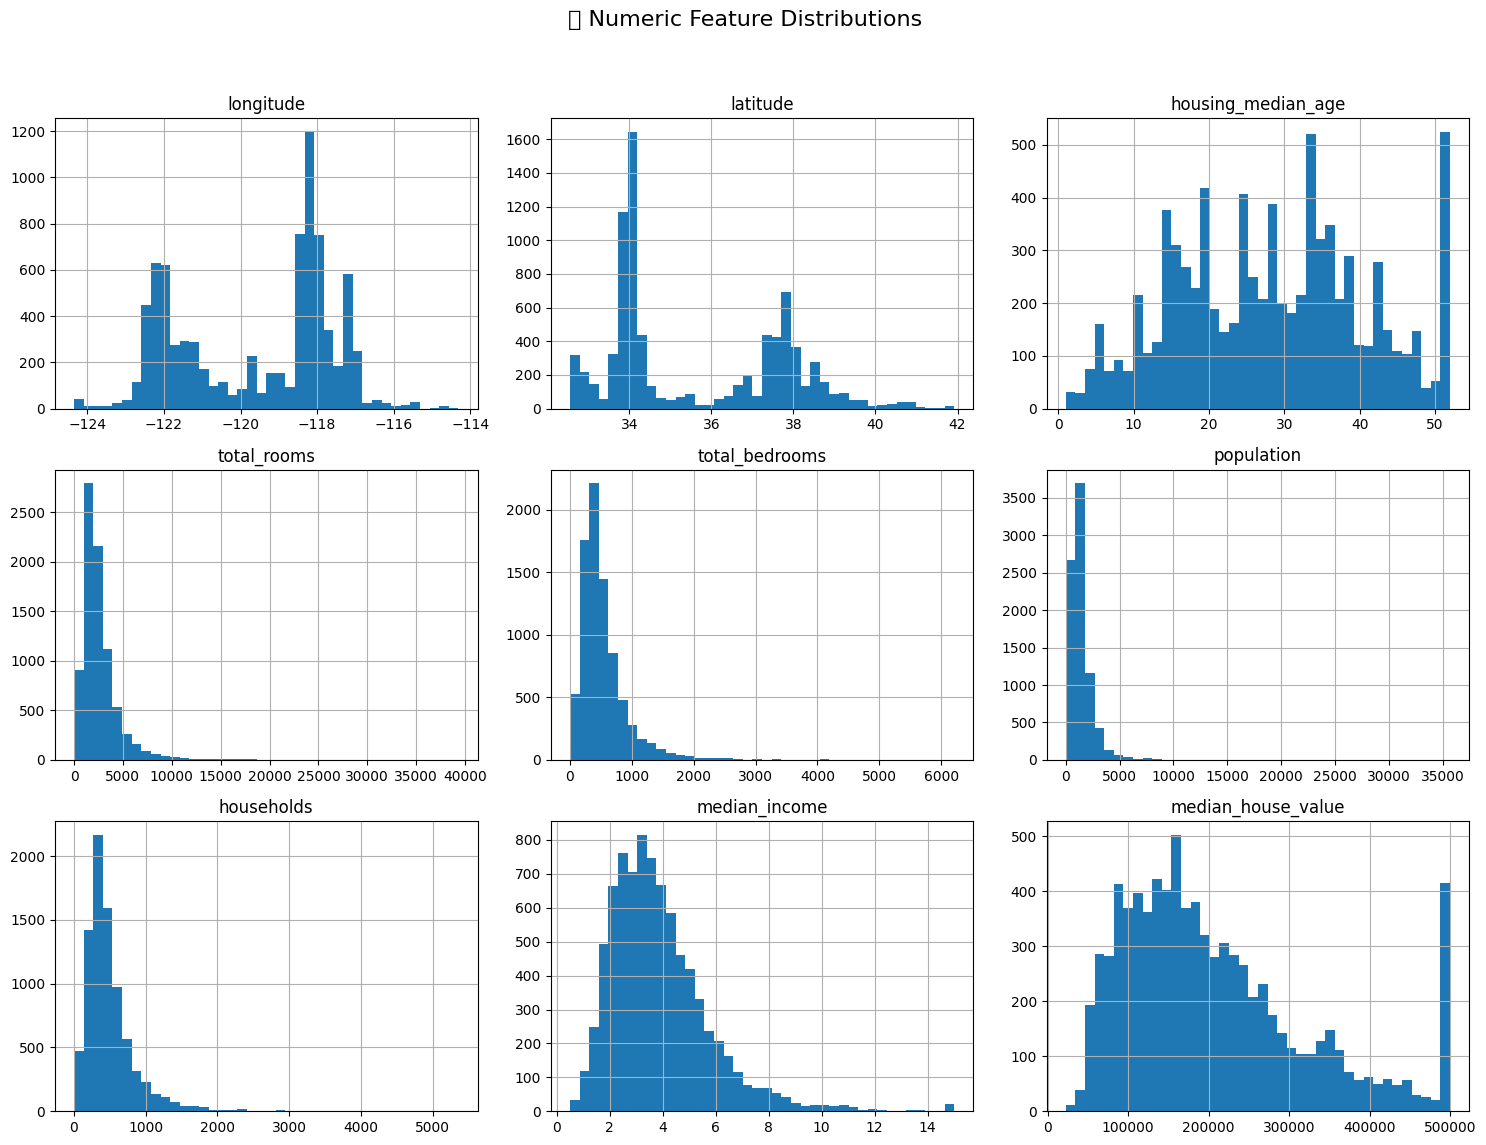

d:\First Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


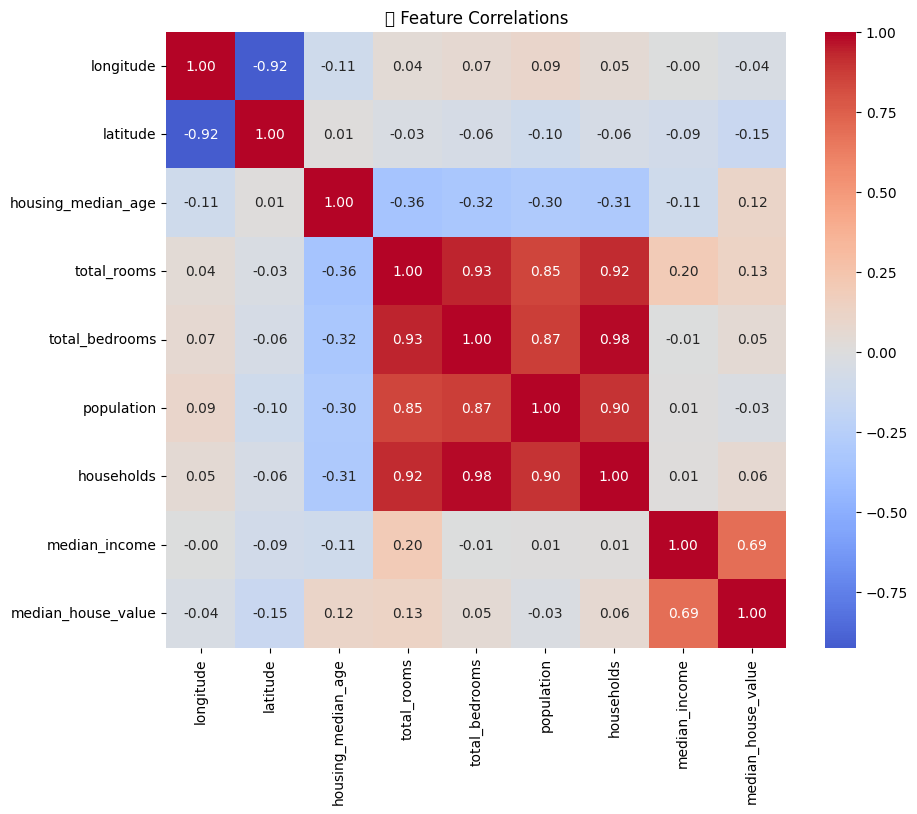

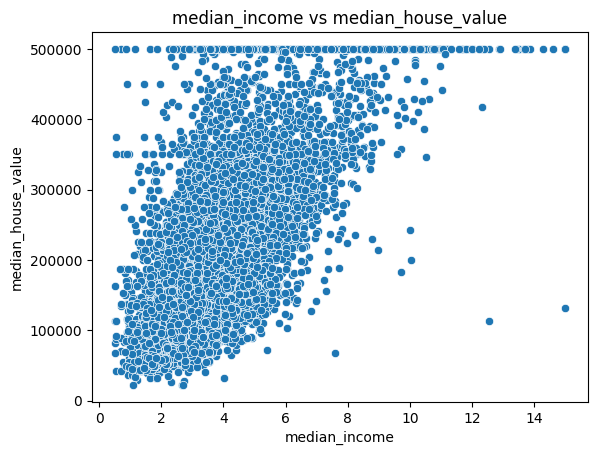

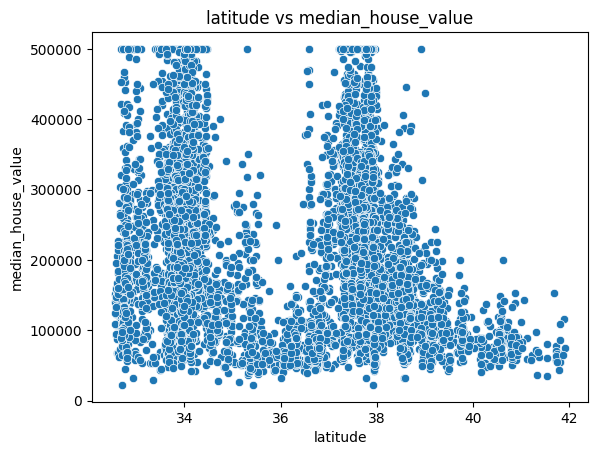

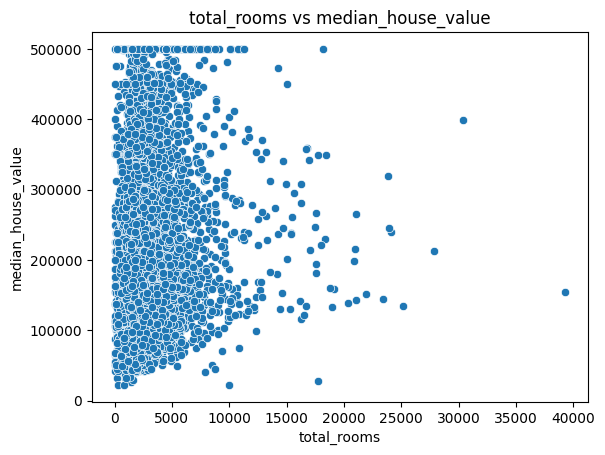

✅ Regression Evaluation:
RMSE:     2410130897.30
R² Score: 0.817


In [22]:
#Step 1: load the data
df = load_housing_data()
target = "median_house_value"


#Step 2: Train and test datasets  
train_set, test_set = stratified_split(df, target_column=target)

#Step 3: Visualize your data 
explore_data(train_set, target_column=target, sample_frac=0.5)
X_train, y_train = frame_problem(train_set, target_column=target)

#Step 4: Prepare your data for ML model
X_train_prepared, pipeline = prepare_data(X_train)
X_test, y_test = frame_problem(test_set, target)
X_test_prepared = pipeline.transform(X_test)  # apply same pipeline

#Step 5: Select and Train a model
model = train_model(X_train_prepared, y_train, model_type="rf", task="regression")
evaluate_model(model, X_test_prepared, y_test, task="regression")

#Step 6: Fine Tune your model

#Step 7: Host your model

In [10]:
print("X_train before:", X_train.shape)
print("X_train after prepare_data:", X_train_prepared.shape)
print("y_train:", y_train.shape)

print("X_test before:", X_test.shape)
print("X_test after prepare_data:", X_test_prepared.shape)
print("y_test:", y_test.shape)

X_train before: (16512, 9)
X_train after prepare_data: (16512, 13)
y_train: (16512,)
X_test before: (4128, 9)
X_test after prepare_data: (4128, 13)
y_test: (4128,)


✅ Shape: (712, 8)

🧠 Data Types:
 survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

🔍 Missing Values:
 survived      0
pclass        0
sex           0
age         137
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

📈 Descriptive Statistics:
           survived      pclass   sex         age       sibsp       parch  \
count   712.000000  712.000000   712  575.000000  712.000000  712.000000   
unique         NaN         NaN     2         NaN         NaN         NaN   
top            NaN         NaN  male         NaN         NaN         NaN   
freq           NaN         NaN   459         NaN         NaN         NaN   
mean      0.383427    2.308989   NaN   29.807687    0.492978    0.390449   
std       0.486563    0.833563   NaN   14.485211    1.060720    0.838134   
min       0.000000    1.000000   NaN    0.420000    0.000000    0.00000

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_27482/4198578072.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # make room for suptitle
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


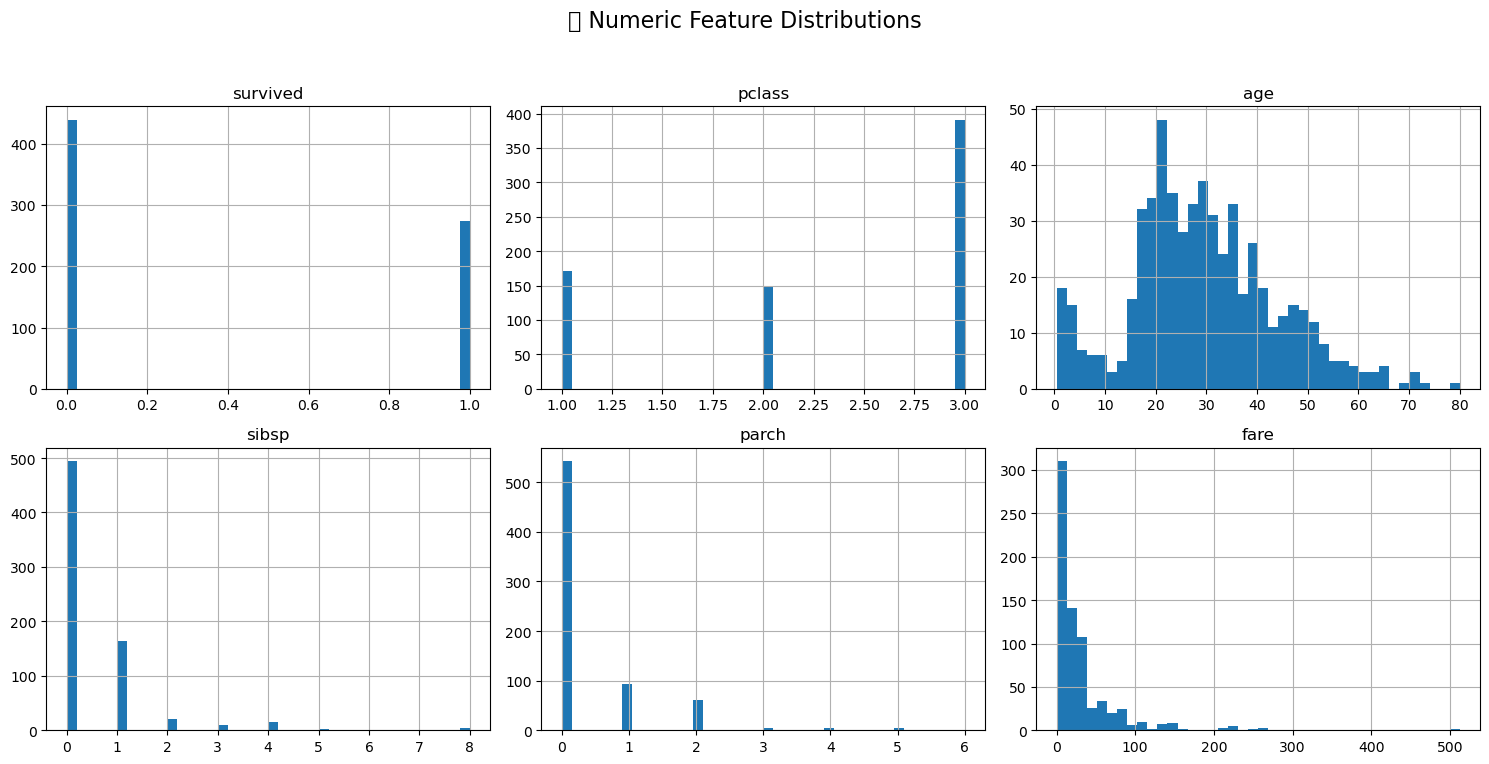

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


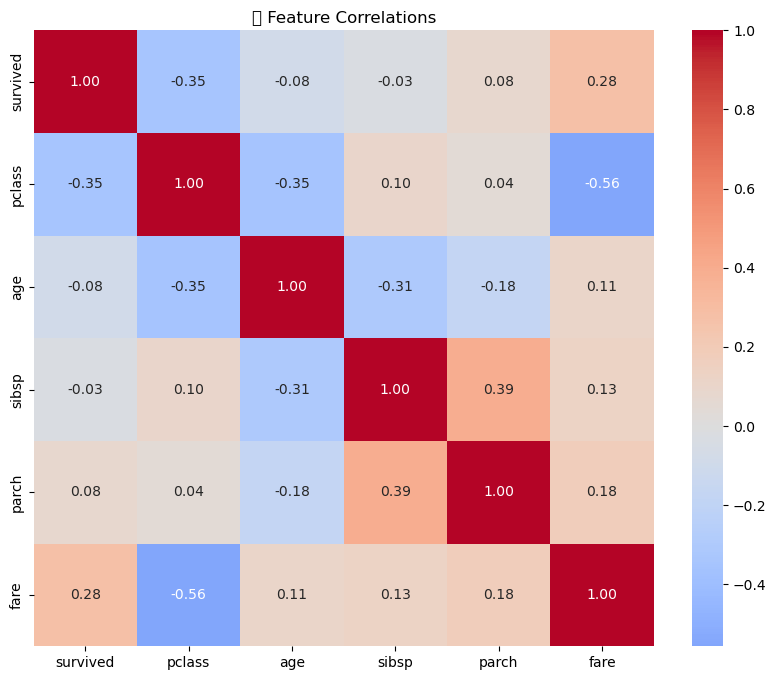

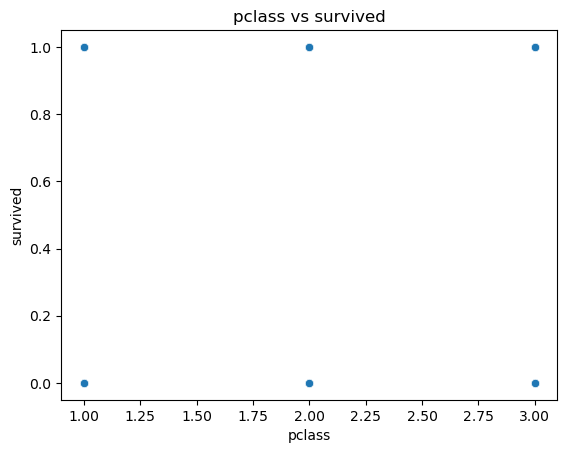

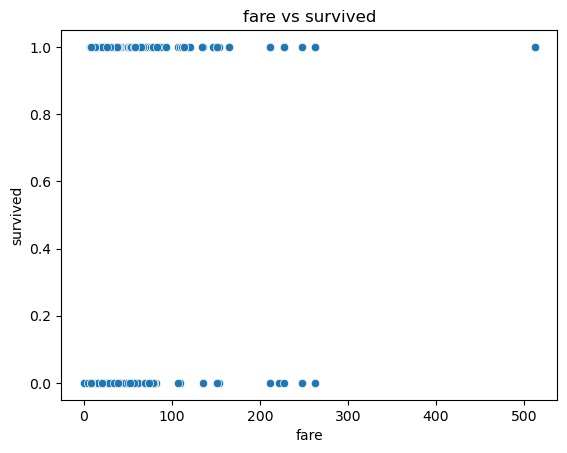

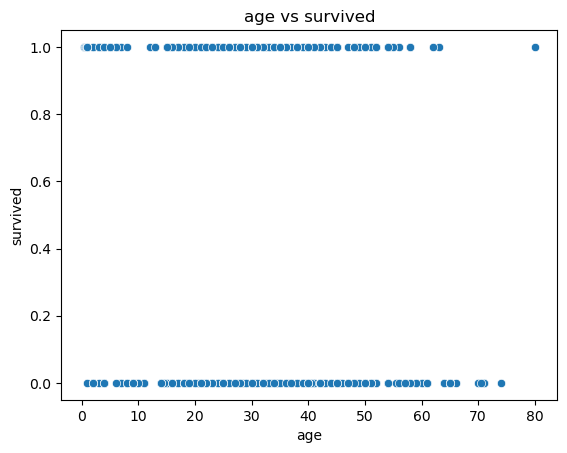

✅ Classification Evaluation:
Accuracy:  0.799
Precision: 0.762
Recall:    0.696
F1 Score:  0.727
Confusion Matrix:
[[95 15]
 [21 48]]


In [11]:
#Step 1: load the data
df1 = sns.load_dataset("titanic").drop(columns=["alive", "class", "who", "adult_male", "deck", "embark_town", "alone"])
target = "survived"
task = "classification"


#Step 2: Train and test datasets  
train_set, test_set = stratified_split(df1, target_column=target)

#Step 3: Visualize your data 
explore_data(train_set, target_column=target, sample_frac=1)
X_train, y_train = frame_problem(train_set, target_column=target)

#Step 4: Prepare your data for ML model
X_train_prepared, pipeline = prepare_data(X_train)
X_test, y_test = frame_problem(test_set, target)
X_test_prepared = pipeline.transform(X_test)  # apply same pipeline

#Step 5: Select and Train a model
model = train_model(X_train_prepared, y_train, model_type="rf", task=task)
evaluate_model(model, X_test_prepared, y_test, task=task)

#Step 6: Fine Tune your model

#Step 7: Host your model

✅ Shape: (16512, 9)

🧠 Data Types:
 MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

🔍 Missing Values:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

📈 Descriptive Statistics:
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16512.000000  16512.000000  16512.000000  16512.000000  16512.000000   
mean       3.880599     28.555656      5.431241      1.095657   1425.342297   
std        1.905039     12.580422      2.386025      0.431179   1143.334777   
min        0.499900      1.000000      0.846154      0.375000      3.000000   
25%        2.564200     18.000000      4.443644      1.005882    785.000000   
50%        3.547700     29.000000      5.240462      1.

/var/folders/rf/w1c5pmc51gvg00xtlws6z9nh0000gn/T/ipykernel_27482/4198578072.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # make room for suptitle
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


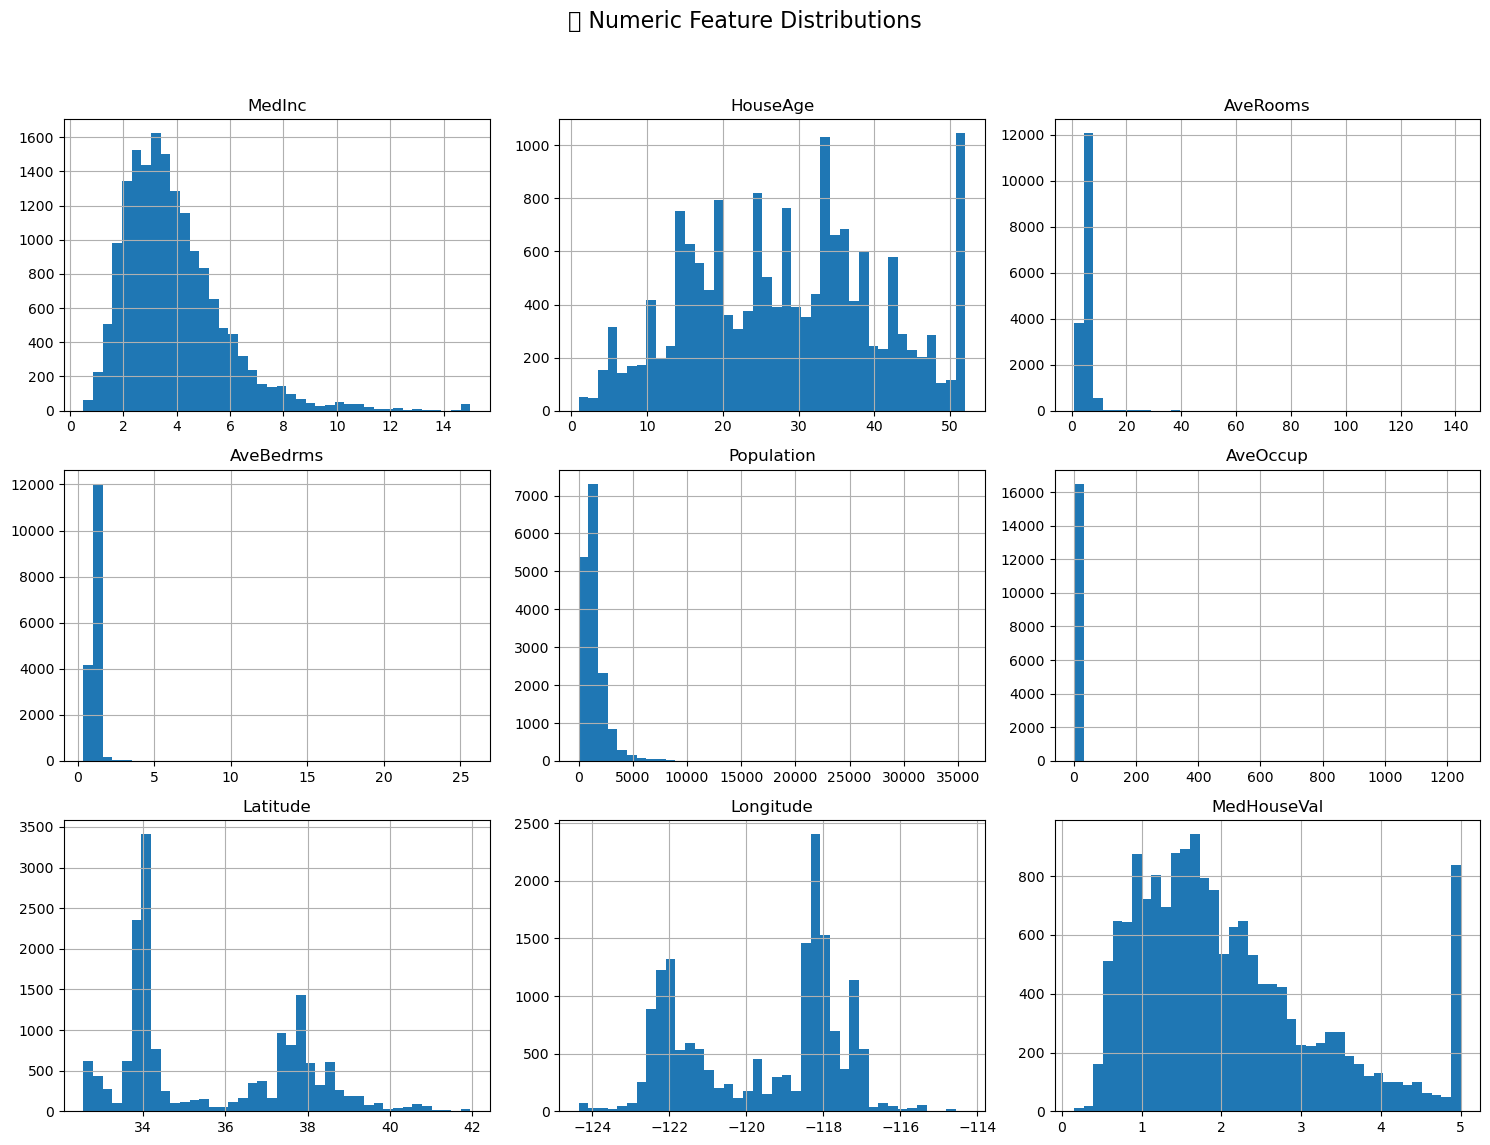

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


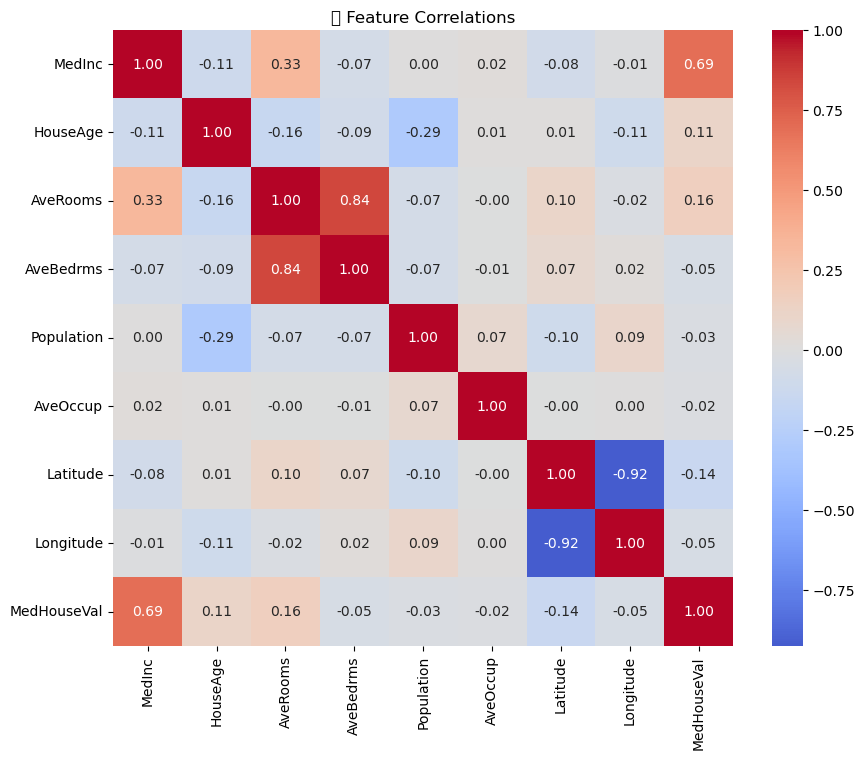

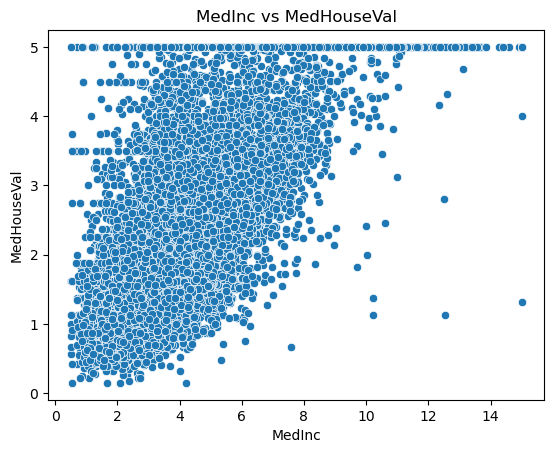

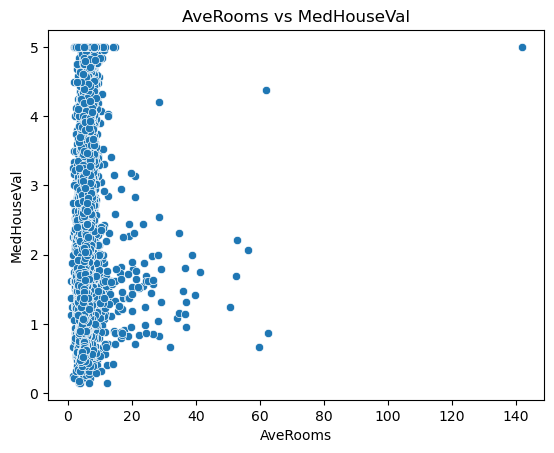

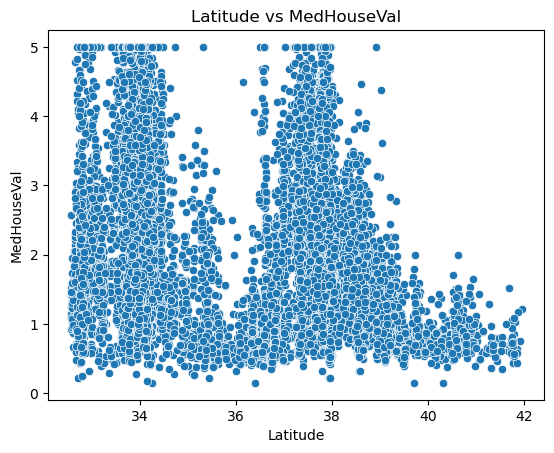

✅ Regression Evaluation:
RMSE:     0.51
R² Score: 0.803


In [12]:
#Step 1: load the data
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing(as_frame=True)
df = california.frame  # already a DataFrame
target = "MedHouseVal"
task = "regression"


#Step 2: Train and test datasets  
train_set, test_set = stratified_split(df, target_column=target)

#Step 3: Visualize your data 
explore_data(train_set, target_column=target, sample_frac=1)
X_train, y_train = frame_problem(train_set, target_column=target)

#Step 4: Prepare your data for ML model
X_train_prepared, pipeline = prepare_data(X_train)
X_test, y_test = frame_problem(test_set, target)
X_test_prepared = pipeline.transform(X_test)  # apply same pipeline

#Step 5: Select and Train a model
model = train_model(X_train_prepared, y_train, model_type="rf", task=task)
evaluate_model(model, X_test_prepared, y_test, task=task)

#Step 6: Fine Tune your model

#Step 7: Host your model